In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

- Import data.

In [43]:
df = pd.read_csv('data/explored_cmv&unpop_data')

In [44]:
df.drop(columns = 'Unnamed: 0', inplace = True)

- Load models.

In [45]:
rf_f1 = pickle.load(open('models/RandomForest.sav', 'rb'))

In [46]:
rf_rocauc = pickle.load(open('models/RandomForest_rocauc.sav', 'rb'))

In [47]:
dtree_f1 = pickle.load(open('models/DecisionTree.sav', 'rb'))

In [48]:
dtree_rocauc = pickle.load(open('models/DecisionTree_rocauc.sav', 'rb'))

In [49]:
et_f1 = pickle.load(open('models/ExtraTrees.sav', 'rb'))

In [50]:
et_rocauc = pickle.load(open('models/ExtraTrees_rocauc.sav', 'rb'))

In [51]:
xgb_f1 = pickle.load(open('models/XGBoost.sav', 'rb'))

In [52]:
xgb_rocauc = pickle.load(open('models/XGBoost_rocauc.sav', 'rb'))

In [53]:
logreg_f1 = pickle.load(open('models/LogisticRegression.sav', 'rb'))

In [54]:
logreg_rocauc = pickle.load(open('models/LogisticRegression_rocauc.sav', 'rb'))

In [55]:
models = {'dtree_f1': dtree_f1, 'dtree_rocauc': dtree_rocauc, 'rf_f1': rf_f1, 'rf_rocauc': rf_rocauc, 
         'et_f1': et_f1, 'et_rocauc': et_rocauc, 'xgb_f1': xgb_f1, 'xgb_rocauc': xgb_rocauc, 
         'logreg_f1': logreg_f1, 'logreg_rocauc': logreg_rocauc}

- Recreate train/test split.

In [56]:
x_list = df.select_dtypes(exclude = np.dtype('O')).columns.tolist()
x_list.remove('post_subreddit')
X = df[x_list]
y = df['post_subreddit']

X = X.astype(np.dtype('float64'))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

- Score models.

In [57]:
model_scores = {}

for name, model in models.items():
    preds = model.predict(X_test)
    model_scores[name] = {}
    
    model_scores[name]['f1'] = f1_score(y_test, preds)
    model_scores[name]['accuracy'] = accuracy_score(y_test, preds)
    model_scores[name]['roc_auc'] = roc_auc_score(y_test, preds)

C:\Users\Avanyali\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Avanyali\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [58]:
model_frame = pd.DataFrame(model_scores)

In [59]:
model_frame

,dtree_f1,dtree_rocauc,rf_f1,rf_rocauc,et_f1,et_rocauc,xgb_f1,xgb_rocauc,logreg_f1,logreg_rocauc
f1,0.00000,0.00000,0.779079,0.00000,0.00000,0.704639,0.824791,0.826855,0.792529,0.791514
accuracy,0.56323,0.56323,0.818557,0.56323,0.56323,0.779038,0.848454,0.848454,0.824399,0.824399
roc_auc,0.50000,0.50000,0.808895,0.50000,0.50000,0.759327,0.844887,0.846211,0.818056,0.817526


- From these we can select only the models that are above baseline accuracy (.56323), ruling out 4 of our 10 models.

In [41]:
model_frame.drop(columns = ['dtree_f1', 'dtree_rocauc', 'rf_rocauc', 'et_f1'], inplace = True)

In [42]:
model_frame

,rf_f1,et_rocauc,xgb_f1,xgb_rocauc,logreg_f1,logreg_rocauc
f1,0.779079,0.704639,0.824791,0.826855,0.792529,0.791514
accuracy,0.818557,0.779038,0.848454,0.848454,0.824399,0.824399
roc_auc,0.808895,0.759327,0.844887,0.846211,0.818056,0.817526


In [21]:
pickle.dump(model_frame, open('models/model_scores.sav', 'wb'))

- Plot XGBoost model features.

In [22]:
def zip_and_sort_features(values):
    zipped = zip(x_list, values)
    features_dict = {entry[0]: entry[1] for entry in zipped}
    #credit to: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    features_dict_sorted = {k: v for k, v in sorted(features_dict.items(), key=lambda item: item[1], reverse = True)}
    return features_dict_sorted

In [23]:
xgb_f1_features_dict_sorted = zip_and_sort_features(xgb_f1.feature_importances_)

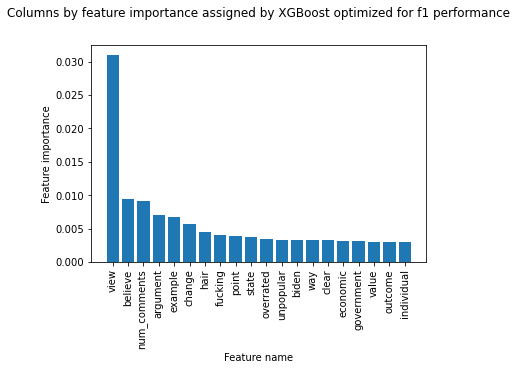

In [24]:
keys = list(xgb_f1_features_dict_sorted.keys())
values = list(xgb_f1_features_dict_sorted.values())

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 90)
plt.title("Columns by feature importance assigned by XGBoost optimized for f1 performance", y= 1.1)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.savefig('images/xgb_f1.png', bbox_inches = 'tight', pad_inches = .3)

In [25]:
xgb_rocauc_features_dict_sorted = zip_and_sort_features(xgb_rocauc.feature_importances_)

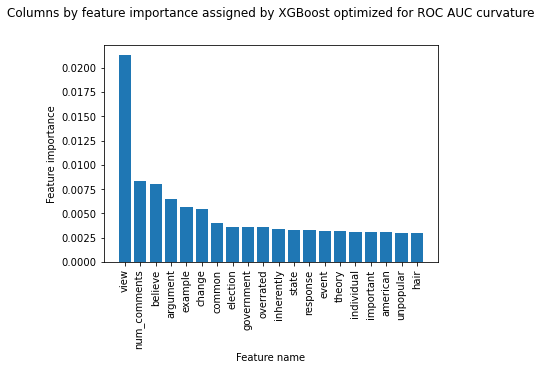

In [26]:
keys = list(xgb_rocauc_features_dict_sorted.keys())
values = list(xgb_rocauc_features_dict_sorted.values())

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 90)
plt.title("Columns by feature importance assigned by XGBoost optimized for ROC AUC curvature", y= 1.1)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.savefig('images/xgb_rocauc.png', bbox_inches = 'tight', pad_inches = .3)

- Plot Random Forest model features.

In [27]:
rf_f1_features_dict_sorted = zip_and_sort_features(rf_f1.feature_importances_)

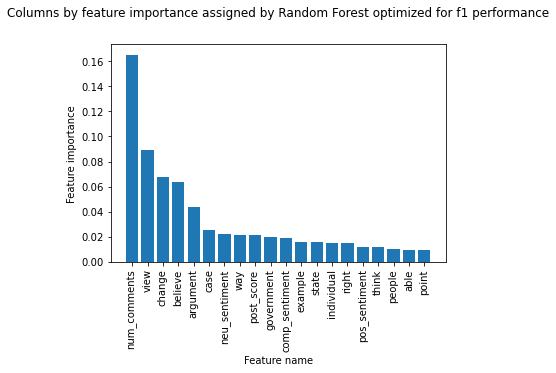

In [28]:
keys = list(rf_f1_features_dict_sorted.keys())
values = list(rf_f1_features_dict_sorted.values())

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 90)
plt.title("Columns by feature importance assigned by Random Forest optimized for f1 performance", y= 1.1)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.savefig('images/rf_f1.png', bbox_inches = 'tight', pad_inches = .3)

- Plot Extra Trees model features.

In [29]:
et_rocauc_features_dict_sorted = zip_and_sort_features(et_rocauc.feature_importances_)

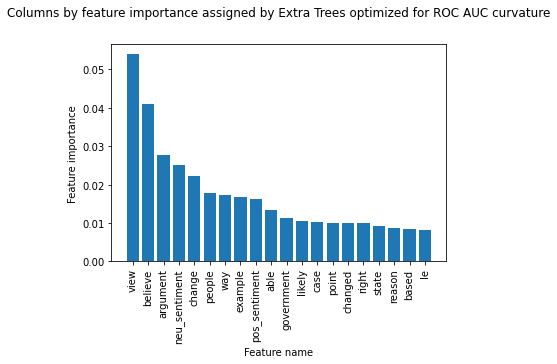

In [30]:
keys = list(et_rocauc_features_dict_sorted.keys())
values = list(et_rocauc_features_dict_sorted.values())

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 90)
plt.title("Columns by feature importance assigned by Extra Trees optimized for ROC AUC curvature", y= 1.1)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.savefig('images/et_rocauc.png', bbox_inches = 'tight', pad_inches = .3)

- Plot Logistic Regression model features.

In [31]:
logreg_f1_features_dict_sorted = zip_and_sort_features(logreg_f1.coef_[0])

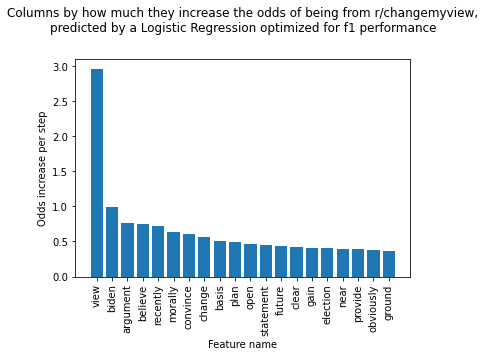

In [32]:
keys = list(logreg_f1_features_dict_sorted.keys())
values = [math.exp(val) - 1 for val in list(logreg_f1_features_dict_sorted.values())]

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 90)
plt.title("Columns by how much they increase the odds of being from r/changemyview,\npredicted by a Logistic Regression optimized for f1 performance", y= 1.1)
plt.ylabel("Odds increase per step")
plt.xlabel("Feature name")
plt.savefig('images/logreg_f1_pos_odds.png', bbox_inches = 'tight', pad_inches = .3)

In [33]:
logreg_f1_features_dict_sorted = zip_and_sort_features(logreg_f1.coef_[0])

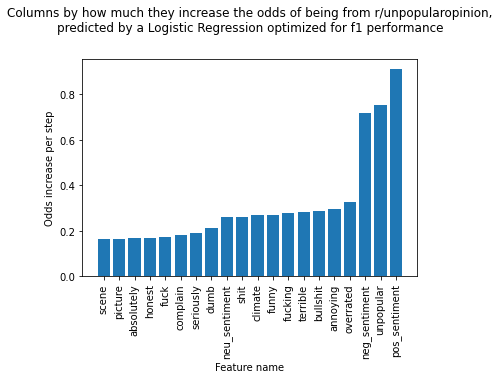

In [34]:
keys = list(logreg_f1_features_dict_sorted.keys())
values = [-1 * (math.exp(val) - 1) for val in list(logreg_f1_features_dict_sorted.values())]

plt.bar(keys[len(keys) - 20:], values[len(values) - 20:])
plt.xticks(rotation = 90)
plt.title("Columns by how much they increase the odds of being from r/unpopularopinion,\npredicted by a Logistic Regression optimized for f1 performance", y= 1.1)
plt.ylabel("Odds increase per step")
plt.xlabel("Feature name")
plt.savefig('images/logreg_f1_neg_odds.png', bbox_inches = 'tight', pad_inches = .3)

In [35]:
logreg_rocauc_features_dict_sorted = zip_and_sort_features(logreg_rocauc.coef_[0])

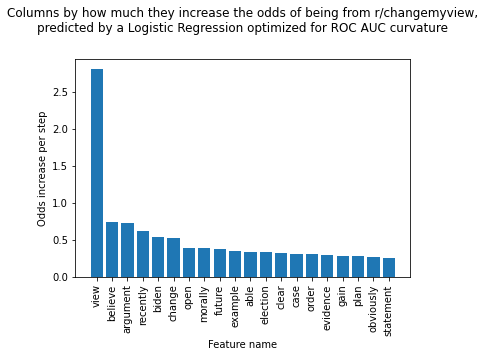

In [36]:
keys = list(logreg_rocauc_features_dict_sorted.keys())
values = [math.exp(val) - 1 for val in list(logreg_rocauc_features_dict_sorted.values())]

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 90)
plt.title("Columns by how much they increase the odds of being from r/changemyview,\npredicted by a Logistic Regression optimized for ROC AUC curvature", y= 1.1)
plt.ylabel("Odds increase per step")
plt.xlabel("Feature name")
plt.savefig('images/logreg_rocauc_pos_odds.png', bbox_inches = 'tight', pad_inches = .3)

In [37]:
logreg_rocauc_features_dict_sorted = zip_and_sort_features(logreg_rocauc.coef_[0])

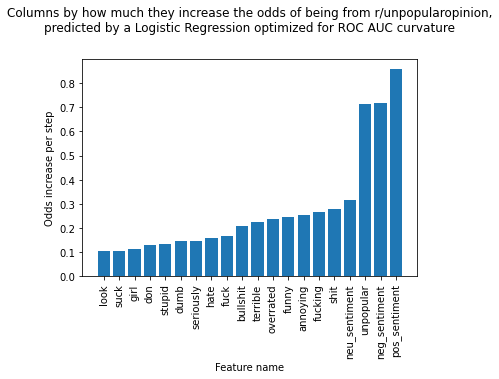

In [38]:
keys = list(logreg_rocauc_features_dict_sorted.keys())
values = [-1 * (math.exp(val) - 1) for val in list(logreg_rocauc_features_dict_sorted.values())]

plt.bar(keys[len(keys) - 20:], values[len(values) - 20:])
plt.xticks(rotation = 90)
plt.title("Columns by how much they increase the odds of being from r/unpopularopinion,\npredicted by a Logistic Regression optimized for ROC AUC curvature", y= 1.1)
plt.ylabel("Odds increase per step")
plt.xlabel("Feature name")
plt.savefig('images/logreg_rocauc_neg_odds.png', bbox_inches = 'tight', pad_inches = .3)

- To step 7 ->